### Feature Engineering

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# ⚡ Quick Setup - Run after runtime reset (CPU/GPU Switch)
# Installs essential packages silently to save output clutter

!pip install matplotlib seaborn pandas numpy missingno --quiet

print("\033[92m✅ All required packages installed successfully.\033[0m")

✅ All required packages installed successfully.


#### Import libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import shutil

#### Load the EDA & Preprocessing notebook

In [6]:
# df2 = pd.read_parquet("/home/data/processed/PreProcessing.parquet")
df2 = pd.read_parquet("/content/drive/MyDrive/datasets/processed/PreProcessingcolab.parquet")

In [7]:
# prompt: remove the time_idx

df2 = df2.drop('time_idx', axis=1, errors='ignore')

#### Time Based Calender features

In [8]:
df2['hour'] = df2['timestamp'].dt.hour
df2['dayofweek'] = df2['timestamp'].dt.dayofweek
df2['is_weekend'] = df2['dayofweek'] >= 5
df2['month'] = df2['timestamp'].dt.month
df2['day'] = df2['timestamp'].dt.day

#### Cyclical Time Features for Time Series Data

In [9]:
# Cyclical encoding for hour
df2['hour_sin'] = np.sin(2 * np.pi * df2['hour'] / 24).round(4)
df2['hour_cos'] = np.cos(2 * np.pi * df2['hour'] / 24).round(4)

# Same for day of week
df2['dayofweek_sin'] = np.sin(2 * np.pi * df2['dayofweek'] / 7).round(4)
df2['dayofweek_cos'] = np.cos(2 * np.pi * df2['dayofweek'] / 7).round(4)

# Optional month encoding if relevant
df2['month_sin'] = np.sin(2 * np.pi * (df2['month'] - 1) / 12).round(4)
df2['month_cos'] = np.cos(2 * np.pi * (df2['month'] - 1) / 12).round(4)

In [10]:
df2.head()

,timestamp,Timestamp [s],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],...,dayofweek,is_weekend,month,day,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
0,2013-08-12 13:45:00,1.376315e+09,4.0,11703.99824,10890.570362,93.050000,67108864.0,6.755624e+06,1.333333,19137.333333,...,0,False,8,12,-0.2588,-0.9659,0.0,1.0,-0.5,-0.866
1,2013-08-12 13:50:00,1.376315e+09,4.0,11703.99824,10434.114431,89.150000,67108864.0,8.947846e+06,2.533333,19974.933333,...,0,False,8,12,-0.2588,-0.9659,0.0,1.0,-0.5,-0.866
2,2013-08-12 13:55:00,1.376316e+09,4.0,11703.99824,10539.450415,90.050000,67108864.0,1.879048e+07,5.466667,8791.800000,...,0,False,8,12,-0.2588,-0.9659,0.0,1.0,-0.5,-0.866
3,2013-08-12 14:00:00,1.376316e+09,4.0,11703.99824,10951.041020,93.566667,67108864.0,9.305761e+06,5.400000,15679.533333,...,0,False,8,12,-0.5000,-0.8660,0.0,1.0,-0.5,-0.866
4,2013-08-12 14:05:00,1.376316e+09,4.0,11703.99824,10913.978359,93.250000,67108864.0,6.352970e+06,4.466667,15553.733333,...,0,False,8,12,-0.5000,-0.8660,0.0,1.0,-0.5,-0.866


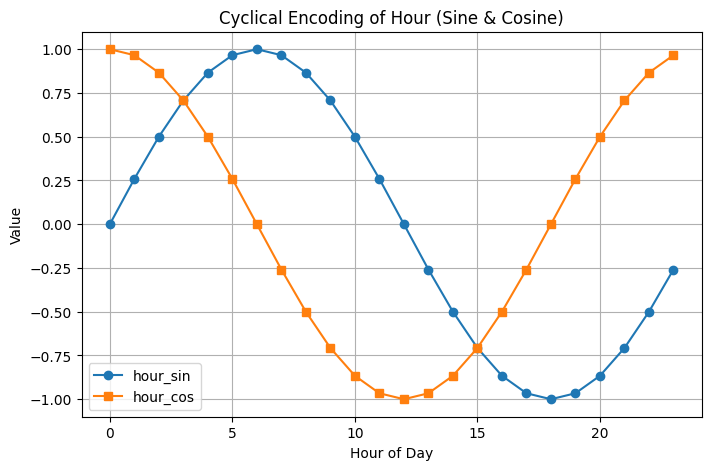

In [11]:
import matplotlib.pyplot as plt

# Example: Plot cyclical encoding for one day (0 to 23 hours)
hours = np.arange(0, 24)
hour_sin = np.sin(2 * np.pi * hours / 24)
hour_cos = np.cos(2 * np.pi * hours / 24)

plt.figure(figsize=(8, 5))
plt.plot(hours, hour_sin, label='hour_sin', marker='o')
plt.plot(hours, hour_cos, label='hour_cos', marker='s')
plt.title("Cyclical Encoding of Hour (Sine & Cosine)")
plt.xlabel("Hour of Day")
plt.ylabel("Value")
plt.grid()
plt.legend()
plt.show()

#### Compute the CPU & Memory usage

In [12]:
df2['cpu_utilization_ratio'] = (df2['CPU usage [MHZ]'] / df2['CPU capacity provisioned [MHZ]']).round(4)
df2['memory_utilization_ratio'] = (df2['Memory usage [KB]'] / df2['Memory capacity provisioned [KB]']).round(4)

# Optional: Convert to percentage view for easy debugging (not for modeling)
# df2['cpu_util_percent'] = (df2['cpu_utilization_ratio'] * 100).round(2)
# df2['memory_util_percent'] = (df2['memory_utilization_ratio'] * 100).round(2)

#### Lag Features Trend Detection of CPU & Memory Features

In [13]:
# Resource Utilization Change Features (Trend Detection)

df2['cpu_util_prev'] = df2.groupby('VM')['cpu_utilization_ratio'].shift(1)
df2['cpu_util_diff'] = df2['cpu_utilization_ratio'] - df2['cpu_util_prev']

df2['memory_util_prev'] = df2.groupby('VM')['memory_utilization_ratio'].shift(1)
df2['memory_util_diff'] = df2['memory_utilization_ratio'] - df2['memory_util_prev']

#### Compute the Disk Usage Ratio, Rolling stats

In [14]:
# Total Disk Throughput
df2['disk_total_throughput'] = (
    df2['Disk read throughput [KB/s]'] + df2['Disk write throughput [KB/s]']
)

# Rolling Average and Std for Disk (window size = 5)
df2['disk_rolling_mean'] = (
    df2.groupby('VM')['disk_total_throughput']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df2['disk_rolling_std'] = (
    df2.groupby('VM')['disk_total_throughput']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)

#### Compute the Network Throughput, Rolling stats

In [15]:
# Total Network Throughput
df2['network_total_throughput'] = (
    df2['Network received throughput [KB/s]'] + df2['Network transmitted throughput [KB/s]']
)

# Rolling Average and Std for Network (window size = 5)
df2['network_rolling_mean'] = (
    df2.groupby('VM')['network_total_throughput']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df2['network_rolling_std'] = (
    df2.groupby('VM')['network_total_throughput']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)

####  Lag Features Trend Detection of Disk & Network Features

In [16]:
# -------------------- Disk Features --------------------
if 'Disk read throughput [KB/s]' in df2.columns:
    df2['disk_read_prev'] = df2.groupby('VM')['Disk read throughput [KB/s]'].shift(1)
    df2['disk_read_diff'] = df2['Disk read throughput [KB/s]'] - df2['disk_read_prev']

if 'Disk write throughput [KB/s]' in df2.columns:
    df2['disk_write_prev'] = df2.groupby('VM')['Disk write throughput [KB/s]'].shift(1)
    df2['disk_write_diff'] = df2['Disk write throughput [KB/s]'] - df2['disk_write_prev']

# -------------------- Network Features --------------------
df2['network_received_prev'] = df2.groupby('VM')['Network received throughput [KB/s]'].shift(1)
df2['network_received_diff'] = df2['Network received throughput [KB/s]'] - df2['network_received_prev']

df2['network_transmitted_prev'] = df2.groupby('VM')['Network transmitted throughput [KB/s]'].shift(1)
df2['network_transmitted_diff'] = df2['Network transmitted throughput [KB/s]'] - df2['network_transmitted_prev']

# Total Network Throughput Change per VM
df2['network_total_prev'] = df2.groupby('VM')['network_total_throughput'].shift(1)
df2['network_total_diff'] = df2['network_total_throughput'] - df2['network_total_prev']

#### Resource Utilization Behavior

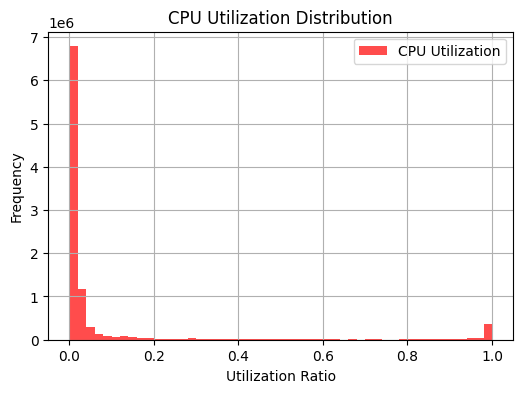

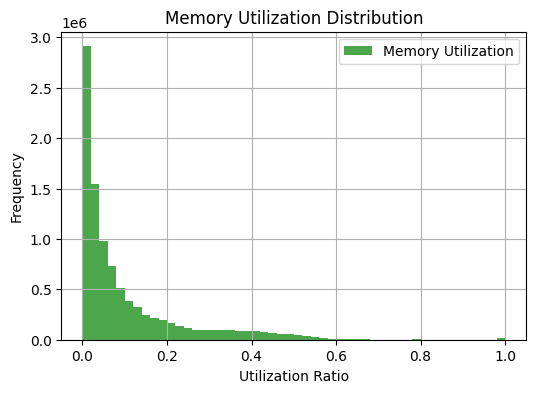

In [17]:
# ✅ First, clip to 0–1 range
df2['cpu_utilization_ratio'] = df2['cpu_utilization_ratio'].clip(0, 1)
df2['memory_utilization_ratio'] = df2['memory_utilization_ratio'].clip(0, 1)

# ✅ Now remove NaNs and infs AFTER clipping
clean_cpu = df2['cpu_utilization_ratio'].replace([np.inf, -np.inf], np.nan).dropna()
clean_mem = df2['memory_utilization_ratio'].replace([np.inf, -np.inf], np.nan).dropna()

# ✅ Plot
plt.figure(figsize=(6, 4))
plt.hist(clean_cpu, bins=50, alpha=0.7, color='red', label='CPU Utilization')
plt.title("CPU Utilization Distribution")
plt.xlabel("Utilization Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.hist(clean_mem, bins=50, alpha=0.7, color='green', label='Memory Utilization')
plt.title("Memory Utilization Distribution")
plt.xlabel("Utilization Ratio")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.show()

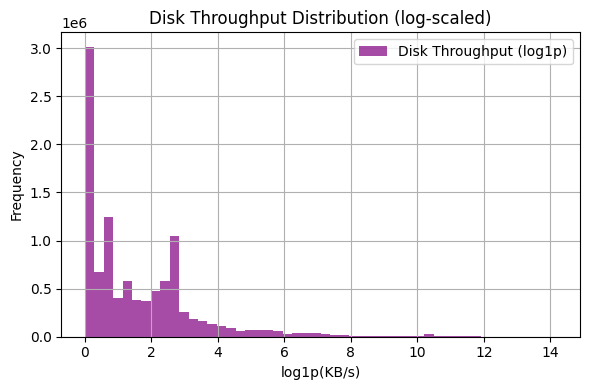

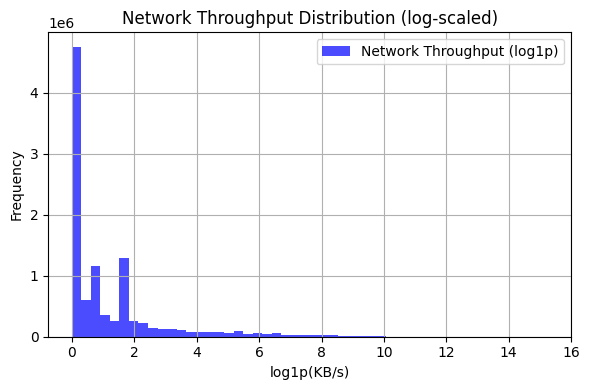

In [18]:
# ✅ Step 1: Clean disk & network throughput columns
clean_disk = df2['disk_total_throughput'].replace([np.inf, -np.inf], np.nan).dropna()
clean_net = df2['network_total_throughput'].replace([np.inf, -np.inf], np.nan).dropna()

# # ✅ Step 2: Apply log1p transformation
log_disk = np.log1p(clean_disk)
log_net = np.log1p(clean_net)

# ✅ Step 3: Plot Disk Throughput Distribution
plt.figure(figsize=(6, 4))
plt.hist(log_disk, bins=50, alpha=0.7, color='purple', label='Disk Throughput (log1p)')
plt.title("Disk Throughput Distribution (log-scaled)")
plt.xlabel("log1p(KB/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ✅ Step 4: Plot Network Throughput Distribution
plt.figure(figsize=(6, 4))
plt.hist(log_net, bins=50, alpha=0.7, color='blue', label='Network Throughput (log1p)')
plt.title("Network Throughput Distribution (log-scaled)")
plt.xlabel("log1p(KB/s)")
plt.ylabel("Frequency")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
df2.columns

Index(['timestamp', 'Timestamp [s]', 'CPU cores',
       'CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'CPU usage [%]',
       'Memory capacity provisioned [KB]', 'Memory usage [KB]',
       'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]',
       'Network received throughput [KB/s]',
       'Network transmitted throughput [KB/s]', 'time_diff', 'VM', 'hour',
       'dayofweek', 'is_weekend', 'month', 'day', 'hour_sin', 'hour_cos',
       'dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos',
       'cpu_utilization_ratio', 'memory_utilization_ratio', 'cpu_util_prev',
       'cpu_util_diff', 'memory_util_prev', 'memory_util_diff',
       'disk_total_throughput', 'disk_rolling_mean', 'disk_rolling_std',
       'network_total_throughput', 'network_rolling_mean',
       'network_rolling_std', 'disk_read_prev', 'disk_read_diff',
       'disk_write_prev', 'disk_write_diff', 'network_received_prev',
       'network_received_diff', 'network_transmitted_prev',
       'n

In [20]:
core_utilization_features = [
    "cpu_utilization_ratio",
    "memory_utilization_ratio",
    "disk_total_throughput",
    "network_total_throughput"
]

lag_diff_features = [
    "cpu_util_prev", "cpu_util_diff",
    "memory_util_prev", "memory_util_diff",
    "disk_read_prev", "disk_read_diff",
    "disk_write_prev", "disk_write_diff",
    "network_received_prev", "network_received_diff",
    "network_transmitted_prev", "network_transmitted_diff",
    "network_total_prev", "network_total_diff"
]

rolling_features = [
    "disk_rolling_mean", "disk_rolling_std",
    "network_rolling_mean", "network_rolling_std"
]

time_features = [
    "hour", "day", "dayofweek", "month",
    "hour_sin", "hour_cos",
    "dayofweek_sin", "dayofweek_cos",
    "month_sin", "month_cos",
    "is_weekend"
]

static_features = [
    "VM"  # Include "vm_type" if available
]

timestamp_features = [
    "timestamp", "Timestamp [s]"
]

In [21]:
common_features_all_targets = (
    core_utilization_features +
    lag_diff_features +
    rolling_features +
    time_features +
    static_features +
    timestamp_features
)

In [ ]:
df3 = df2[common_features_all_targets].copy()

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

print(df3.isna().sum().sort_values(ascending=False))

In [ ]:
df3 = df2[core_utilization_features + lag_diff_features + rolling_features + time_features + static_features + timestamp_features].copy()
print(df3.isna().sum().sort_values(ascending=False))

In [ ]:
# Step 1: Fill targets with forward-fill + backfill per VM
tarc = ["cpu_utilization_ratio", "memory_utilization_ratio"]
# Use transform instead of apply to maintain the original index
df3[tarc] = df3.groupby("VM")[tarc].transform(lambda x: x.ffill().bfill())

In [ ]:
# Step 2: Fill lag/diff columns with 0

df3[lag_diff_features] = df3[lag_diff_features].fillna(0)

In [ ]:
# Step 3: Recalculate rolling features to fix NaNs from rolling window start
df3["disk_rolling_mean"] = df3.groupby("VM")["disk_total_throughput"].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df3["disk_rolling_std"] = df3.groupby("VM")["disk_total_throughput"].transform(lambda x: x.rolling(window=5, min_periods=1).std())

df3["network_rolling_mean"] = df3.groupby("VM")["network_total_throughput"].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df3["network_rolling_std"] = df3.groupby("VM")["network_total_throughput"].transform(lambda x: x.rolling(window=5, min_periods=1).std())

In [ ]:
# Step 4: Final drop remaining NaNs (if any)
df3.dropna(inplace=True)

In [ ]:
import numpy as np

df3.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
import numpy as np

# Check for remaining NaNs
nan_summary = df3.isna().sum()
print("🔍 Remaining NaNs:\n", nan_summary[nan_summary > 0])

# Check for infinities
inf_check = np.isinf(df3.select_dtypes(include=[np.number])).sum()
print("🔍 Infinities:\n", inf_check[inf_check > 0])

In [ ]:
# View again
inf_cols = ["cpu_util_prev", "cpu_util_diff", "memory_util_prev", "memory_util_diff"]
df3[inf_cols].isna().sum()

In [ ]:
df3[inf_cols] = df3[inf_cols].fillna(0)

In [ ]:
# View again
inf_cols = ["cpu_util_prev", "cpu_util_diff", "memory_util_prev", "memory_util_diff"]
df3[inf_cols].isna().sum()

In [ ]:
df5 = df2[core_utilization_features + lag_diff_features + rolling_features + time_features + static_features + timestamp_features].copy()
print(df5.isna().sum().sort_values(ascending=False))

In [ ]:
import numpy as np

# Check for NaNs, Infs, and duplicates
print("🧼 Final Data Validation Summary:")
print("-" * 40)
print(f"🚫 NaNs present: {df3.isna().sum().sum()}")  # Total NaNs
print(f"♾️ Infs present: {np.isinf(df3.select_dtypes(include=[np.number])).sum().sum()}")  # Total Infs
print(f"🌀 Duplicate rows: {df3.duplicated().sum()}")
print(f"✅ Final shape: {df3.shape}")

In [ ]:
vm_lengths = df3.groupby("VM").size()

In [ ]:
vm_lengths

In [ ]:
vm_stats = df3.groupby("VM").agg(
    total_rows = ("timestamp", "count"),
    cpu_mean = ("cpu_utilization_ratio", "mean"),
    cpu_std = ("cpu_utilization_ratio", "std"),
    mem_mean = ("memory_utilization_ratio", "mean"),
    mem_std = ("memory_utilization_ratio", "std"),
    nan_ratio = (lambda x: x.isna().mean())  # or compute for key cols separately
)

In [ ]:
asdfasdf

In [ ]:
min_len = 60  # example 48 + 12
valid_vms = vm_stats[vm_stats["total_rows"] >= min_len]

In [ ]:
# Correlation matrix b/w targets

In [ ]:
# Define targets
target_cols = [
    'cpu_utilization_ratio',
    'memory_utilization_ratio',
    'disk_total_throughput',
    'network_total_throughput'
]

# Compute correlation matrix
corr_matrix = df2[target_cols].corr()

print(corr_matrix)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Title and layout
plt.title("🔗 Correlation Matrix of Resource Utilization Metrics", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

In [ ]:
print(df2.columns.tolist())

#### Save the cleaned DataFrame to a Parquet file

In [ ]:
# df2.to_parquet("/home/data/processed/FeatureEng.parquet", index=False)
# df2.to_parquet("/content/drive/MyDrive/datasets/processed/FeatureEngcolab.parquet", index=False)

# Define save path
save_path = "/content/drive/MyDrive/datasets/processed/FeatureEngcolab"

# Step 1: Clean old folders
shutil.rmtree(save_path, ignore_errors=True)

# Step 2: Re-save from your cleaned df2
df2.to_parquet(save_path, partition_cols=["VM"], index=False)

print("✅ Clean overwrite done.")